In [1]:
import pygimli as pg
from pygimli.physics import TravelTimeManager
import pygimli.physics.traveltime as tt

In [2]:

data = tt.load("koenigsee.sgt")
data["err"] = 0.001
mgr = tt.TravelTimeManager(data=data, secNodes=4)
mgr.invert(absoluteError=0.001, vTop=300, vBottom=3000, quality=34.4)

09/08/23 - 12:19:18 - pyGIMLi - INFO - Found 1 regions.
09/08/23 - 12:19:18 - pyGIMLi - INFO - Found 1 regions.
09/08/23 - 12:19:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
09/08/23 - 12:19:18 - pyGIMLi - INFO - Creating refined mesh (secnodes: 4) to solve forward task.
09/08/23 - 12:19:18 - pyGIMLi - INFO - Create gradient starting model. 300: 3000
09/08/23 - 12:19:18 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00320332 0.00272708 0.0031635  ... 0.00035835 0.00046331 0.00037864]


1358 [952.8893227620416,...,3168.814139424009]

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2535f35bd60>)

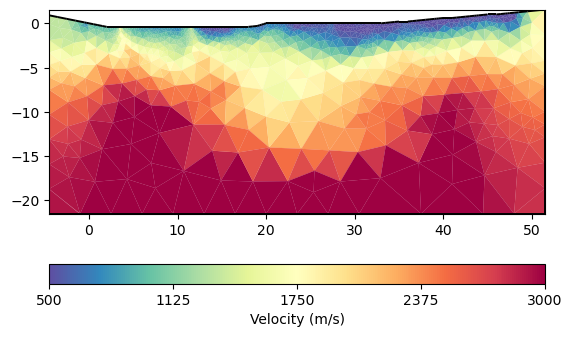

In [3]:
mgr.showResult(cMin=500, cMax=3000, logScale=False, cMap="Spectral_r")

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2535f5bcca0>)

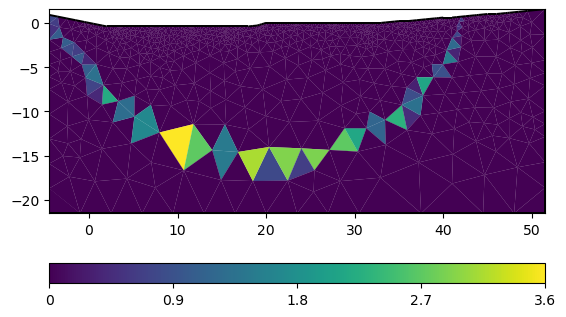

In [4]:
pg.show(mgr.paraDomain, mgr.fop.jacobian().row(40))

In [5]:
print(mgr.fop.mesh())

Mesh: Nodes: 762 Cells: 1358 Boundaries: 2119 secNodes: 8476


In [6]:
from importlib import reload
reload(tt)

<module 'pygimli.physics.traveltime' from 'c:\\Guenther.T\\src\\gimli\\gimli\\pygimli\\physics\\traveltime\\__init__.py'>

In [10]:
mgr = tt.TravelTimeManager(data=data, fatray=True, secNodes=2)
mgr.invert(absoluteError=0.001, vTop=300, vBottom=3000)

09/08/23 - 12:20:02 - pyGIMLi - INFO - Found 1 regions.
09/08/23 - 12:20:02 - pyGIMLi - INFO - Found 1 regions.
09/08/23 - 12:20:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
09/08/23 - 12:20:02 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
09/08/23 - 12:20:02 - pyGIMLi - INFO - Create gradient starting model. 300: 3000
09/08/23 - 12:20:02 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00299976 0.00281699 0.002855   0.00304669 0.00323872 0.00324358
 0.00332439 0.0033261  0.00324358 0.00298085 0.00323945 0.00293113
 0.00310268 0.00328547 0.00269688 0.00300251 0.00328547 0.0032893
 0.00322371 0.00307189 0.00315726 0.0032177  0.00313331 0.00324566
 0.0028197  0.00270994 0.00322362 0.00234554 0.00292677 0.00331614
 0.0023563  0.00327109 0.0032216  0.00319676 0.00296124 0.00296276
 0.00315452 0.00306567 0.00276784 0.00289495 0.00327109 0.00306846
 0.00234497 0.00322291 0.003173   0.003323   0.00323383 0.00285204
 0.0022225  0

RuntimeError: ./core/src/mesh.cpp:917		GIMLI::Cell* GIMLI::Mesh::findCell(const GIMLI::RVector3&, size_t&, bool) const  no cells for this node. This is a corrupt mesh

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2535f6afa90>)

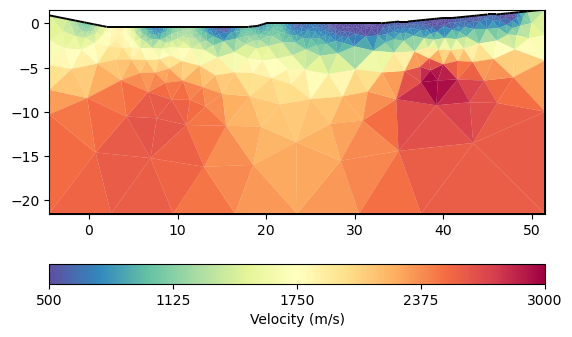

In [8]:
mgr.showResult(cMin=500, cMax=3000, logScale=False, cMap="Spectral_r")

RMatrix: 714 x 888
888 [0.0913284058082518,...,0.0635250029367672]


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2536086c4f0>)

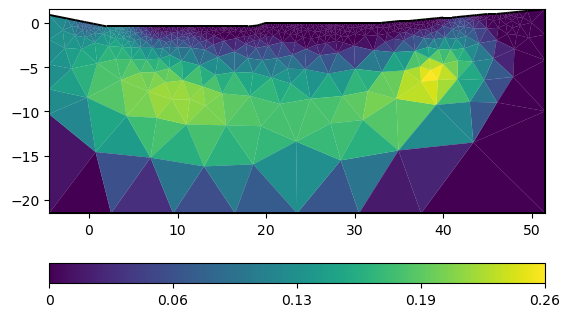

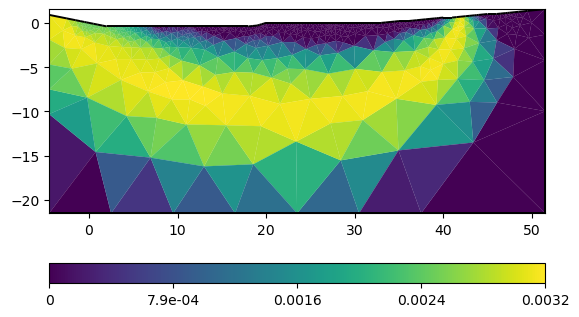

In [9]:
J = mgr.fop.J  # jacobian()
print(J)
j40 = J.row(40)
print(j40)
pg.show(mgr.paraDomain, j40)
pg.show(mgr.paraDomain, mgr.fop.FresnelWeight[40])

import numpy as np
self = mgr.fop
mesh = self.mesh()
slowness = pg.Vector(mesh.cellCount(), 0.001)
self.J = pg.Matrix(self.data.size(), mesh.cellCount())
self.sensorNodes = [mesh.findNearestNode(pos)
                    for pos in self.data.sensorPositions()]
if (self.iMat.cols() != mesh.nodeCount() or
        self.iMat.rows() != mesh.cellCount()):
    self.iMat = mesh.interpolationMatrix(mesh.cellCenters())

Di = self.dijkstra
slowPerCell = self.createMappedModel(slowness, 1e16)
Di.setGraph(self._core.createGraph(slowPerCell))
numN = mesh.nodeCount()
data = self.data
numS = data.sensorCount()
Tmat = pg.Matrix(numS, numN)
Dmat = pg.Matrix(numS, numS)
for i, node in enumerate(self.sensorNodes):
    Di.setStartNode(node)
    Tmat[i] = Di.distances()  # (0, numN)
    Dmat[i] = Tmat[i][self.sensorNodes]

for i in range(data.size()):
    iS = int(data("s")[i])
    iG = int(data("g")[i])
    tsr = Dmat[iS][iG]  # shot-receiver travel time
    dt = self.iMat * (Tmat[iS] + Tmat[iG]) - tsr
    weight = np.maximum(1 - 2 * self.frequency * dt, 0.0)  # 1 on ray
    wa = weight  # * np.sqrt(self.mesh().cellSizes())
    if np.sum(wa) > 0:  # not if all values are zero
        wa /= np.sum(wa)

    self.J[i] = wa * tsr / slowness
pg.show(mesh, weight)#self.J.row(40))